# Assignment: incompressible compositional transport for binary mixture


We introduce the mole number of component: $n_i$.

Overal molar fraction of component: $z_i = {n_i}/{n_{tot}}$, where $n_{tot}=\sum n_j$.

In two phase state, mole numebr of component splits to $n_i = n_i^L + n_i^V$.

Total number of moles is defined as
\begin{equation}
n_{tot} = \sum n_i^L + \sum n_i^V = n^L + n^V \quad \Rightarrow \quad 1 = \frac{n^L}{n_{tot}} + \frac{n^V}{n_{tot}} = L + V
\end{equation}

Overal molar fraction can be represented as
\begin{equation}
z_i = \frac{n_i^L}{n_{tot}} + \frac{n_i^V}{n_{tot}} = \frac{n_i^L}{n^L} \frac{n^L}{n_{tot}} + \frac{n_i^V}{n^V}\frac{n^V}{n_{tot}} = x_i L + y_i V \qquad \qquad \qquad (*)
\end{equation}

Finally, algebraic constrans for $x_i$ and $y_i$ are defined as
\begin{equation}
\sum x_i = \sum \frac{n_i^L}{n^L} = 1, \quad \sum y_i = \sum \frac{n_i^V}{n^V} = 1  \quad \Rightarrow \quad \sum x_i - \sum y_i = 0 \qquad \qquad \qquad (**)
\end{equation}

Let's introduce particioning coefficients $K_i = y_i / x_i$. NExt we can substitute $y_i = K_i x_i$ and $L = 1 - V$ into equation $(*)$:

\begin{equation}
z_i = x_i (1-V) + K_i x_i V = x_i(1-V + K_i V) = x_i (V(K_i-1)+1),
\end{equation}

and $x_i$ can be found as
\begin{equation}
x_i = \frac{z_i}{V(K_i-1)+1}, \quad y_i = K_i x_i = \frac{K_i z_i}{V(K_i-1)+1}.
\end{equation}

Fanally, we can substitute $x_i$ and $y_i$ into equations $(**)$:

\begin{equation}
\sum x_i - \sum y_i = \sum \frac{z_i}{V(K_i-1)+1} - \sum \frac{K_i z_i}{V(K_i-1)+1} = \sum \frac{z_i (K_i -1)}{V(K_i-1)+1}
\end{equation}






In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import timeit

def RachforRice(z, K):
    r = lambda v: np.sum(z * (K - 1) / (v * (K - 1) + 1))
    a = 1 / (1 - np.max(K))
    b = 1 / (1 - np.min(K))

    for i in range(1000):
        v = 0.5 * (a + b)
        if r(v) > 0:
            a = v
        else:
            b = v

        if np.abs(r(v)) < 1e-12:
            break

    x = z / (v * (K - 1) + 1)
    y = K * x

    return x, y


Fractional flow function is defined as

\begin{equation}
f = \frac{\lambda_o}{\lambda_o + \lambda_g} = \frac{k_{ro}}{k_{ro} + M k_{rg}}, \ M = \frac{\mu_o}{\mu_g},
\end{equation}

with corresponding derivative

\begin{equation}
\frac{\partial f}{\partial s} = \frac{k'_{ro}}{k_{ro} + M k_{rg}} - \frac{k_{ro}(k'_{ro} + M k'_{rg})}{(k_{ro} + M k_{rg})^2}.
\end{equation}



In [2]:
M = 10
f  = lambda s: s**2 / (s**2 + M * (1 - s)**2)
df_ds = lambda s: 2 * s / (s**2 + M * (1 - s)**2) - \
    s**2 * (2 * s - M * 2 * (1 - s)) / (s**2 + M * (1 - s)**2)**2

Conservation equation for incomprssible problem can be written as

\begin{equation}
r_{c,i}= (z_c)_i^{n+1} -(z_c)_i^{n} +  \Theta \left[(F_c)_{i+1/2} - (F_c)_{i-1/2}\right]=0.
\label{simpl_res}
\end{equation}


Here we defined

\begin{equation}
\Theta = \frac{U_t}{\phi}\frac{\Delta t}{\Delta x}, \quad
F_c = \frac{x_c \lambda_o + y_c \lambda_g}{\lambda_o + \lambda_g} = x_c f + y_c (1-f),
\label{functions_res}
\end{equation}

where $f$ is a fractional flow function of the liquid phase defined above.

In [ ]:
def simulate_comp_expl(nb, Theta_ref, NT):
    start = timeit.default_timer()
    z_inj = 0.99
    K = np.array([3, 0.1])    
    
    z = np.ones(nb) * 0.01
    z[0] = z_inj


    zf = np.array([0.5, 0.5]) 
    x, y = RachforRice(zf, K) # Single flash is enough for binary system
    
    Theta = Theta_ref
    for t in range(NT):
        s = (z - y[0]) / (x[0] - y[0])
        F = x[0] * f(s) + y[0] * (1 - f(s))
        F[s > 1] = z[s > 1]
        F[s < 0] = z[s < 0]
        z[1:nb] -= Theta * (F[1:nb] - F[0:nb-1])


    stop = timeit.default_timer()

    print('CPU = %5.3f sec, NT = %d' % ((stop - start), t))

    return z


For implicit compositional transport problem, we need to solve nonlienar vector equation:

\begin{equation}
\bf r(z^{n+1,k+1}) = 0
\end{equation}


We apply the Newton-Raphson method for the solution of this equation:

\begin{equation}
{\bf J(z^{n+1,k})} \Delta {\bf z} = - \bf r(z^{n+1,k})
\label{newt_raph_comp}
\end{equation}

Here $\Delta {\bf z} = \{{\bf z}^{n+1,k+1}-{\bf z}^{n+1,k}\}$, $k$ is the Newton's iteration and $\bf J$ is Jacobian entry: 
\begin{equation}
{\bf J} = \left[J_{ij}\right]=\left[  \frac{\partial r_{i} }{\partial z_{j}} \right].
\label{jacobian_comp}
\end{equation}


Here each entry $J_{ij}$ in Jacobian is a matrix of $[n_c\times n_c]$ size, where $n_c$ is the number of components.


In [4]:
def simulate_comp_impl(nb, Theta_ref, NT):
    start = timeit.default_timer()
    z_inj = 0.99

    z = np.ones(nb) * 0.01
    z[0] = z_inj
    
    K = np.array([3, 0.1])   

    i = 0
    zf = np.array([z[i], 1-z[i]])
    x, y = RachforRice(zf, K)
    
    Theta = Theta_ref
    rhs = np.zeros(nb)
    jac = np.zeros([nb, nb])
    nit = 0
    rn = range(1, nb)
    for t in range(NT):
        zn = np.array(z, copy=True)
        for n in range(100):
            if 0: # implicit
                s = (z - y[0]) / (x[0] - y[0])
                F = x[0] * f(s) + y[0] * (1 - f(s))
                F[s > 1] = z[s > 1]
                F[s < 0] = z[s < 0]

                rhs[rn] = z[rn] - zn[rn] + Theta * (F[rn] - F[0:nb-1])
                jac[0, 0] = 1.0
                for i in rn:
                    jac[i, i] = 1.0 + Theta * df_ds(s[i])
                    jac[i, i-1] = - Theta * df_ds(s[i-1])

            else: # explicit
                s = (zn - y[0]) / (x[0] - y[0])
                F = x[0] * f(s) + y[0] * (1 - f(s))
                F[s > 1] = z[s > 1]
                F[s < 0] = z[s < 0]

                rhs[rn] = z[rn] - zn[rn] + Theta * (F[rn] - F[0:nb-1])
                jac[0, 0] = 1.0
                for i in rn:
                    jac[i, i] = 1.0 

                res = np.linalg.norm(rhs)
                if (res < 1e-4):
                    # print("T = %d, iter = %d, res = %e" % (t, n, res))
                    nit += n
                    break

                dz = np.linalg.solve(jac, -rhs)
                z += dz


    stop = timeit.default_timer()

    print('CPU = %5.3f sec, NT = %d, NI = %d' % ((stop - start), t, nit))

    return z


CPU = 0.004 sec, NT = 99
CPU = 0.057 sec, NT = 99, NI = 648


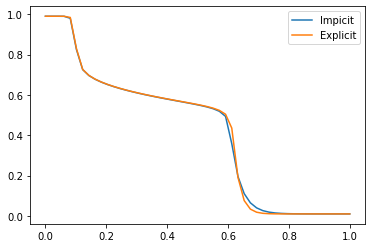

In [13]:
nb = 50
Theta = 0.2
NT = 100
z2 = simulate_comp_expl(nb, Theta, NT=NT)
z1 = simulate_comp_impl(nb, Theta, NT=NT)


x1 = np.linspace(0, 1, nb)
plt.plot(x1, z1)
plt.plot(x1, z2)
plt.legend(["Impicit", "Explicit"])